Twoim zadaniem jest wytrenowanie klasyfikatora binarnego na podzbiorze zbioru MNIST, w którym wyróżniamy klasy (cyfry 0 i 1 mają zostać wyłączone ze zbioru):
 - Liczby pierwsze (2,3,5,7)
 - Liczby złożone (4,6,8,9)

Napisz wydajną implementację modelu **regresji logistycznej** trenowanego algorytmem ***SGD z momentum***. Cały proces trenowania musisz napisać samodzielnie, w języku Python, korzystając z biblioteki numpy. Na potrzeby zadania niedozwolone jest korzystanie z gotowych implementacji optimizerów i modeli oraz bibliotek do automatycznego różniczkowania funkcji (np. Tensorflow, pytorch, autograd). 

Dobierz hiperparametry tak, aby uzyskać jak najlepszy wynik na zbiorze walidacyjnym. 
Wyciągnij i zapisz wnioski z przeprowadzonych eksperymentów.

Zbiór MNIST dostępny jest pod linkami: 

(zbiór treningowy):
 - http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
 - http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz

(zbiór walidacyjny):
 - http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
 - http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

Import dataset and reshape it

In [1]:
import numpy as np

data = np.fromfile(file='train-images-idx3-ubyte',dtype=np.uint8)
X_train = data[16:].reshape((60000,28*28)).astype(np.float128)

data = np.fromfile(file='train-labels-idx1-ubyte',dtype=np.uint8)
y_train = np.asarray(data[8:].reshape(60000))

data = np.fromfile(file='t10k-images-idx3-ubyte',dtype=np.uint8)
X_test = data[16:].reshape((10000,28*28)).astype(np.float128)

data = np.fromfile(file='t10k-labels-idx1-ubyte',dtype=np.uint8)
y_test = np.asarray(data[8:].reshape(10000))

Remove (0,1) values and change labels: (2,3,5,7) = 0, (4,6,8,9) = 1

In [2]:
def drop_zero_one(X, y):
    indexes = []
    for i in range(len(y)):
        if y[i] in [0,1]:
            indexes.append(i)
    X = np.delete(X, indexes, axis=0)
    return X.reshape((-1,28*28)), np.delete(y, indexes)

X_train_drop, y_train_drop = drop_zero_one(X_train, y_train)
X_test_drop, y_test_drop = drop_zero_one(X_test, y_test)

n_samples_train = len(y_train_drop)
n_samples_test = len(y_test_drop)

for i in range(n_samples_train):
    y_train_drop[i]  = y_train_drop[i] in [4,6,8,9]

for i in range(n_samples_test):
    y_test_drop[i] =  y_test_drop[i] in [4,6,8,9]

# Logistic Regression using Stochastic Gradient Descend with Momentum.

In order to reach best results on our validation set, there is also adaptive gradient (Adagrad) improvement included.

In [3]:
class SGD_logistic_regression:

    def __init__(self, n_epochs: int=10, learning_rate: float=0.1, momentum_const: float=0, adagrad: bool=False,
                 save_accuracy_values: bool=False, numerical_epsilon: float=1e-7, tolerance: float=0):
        """
        :param n_epochs:    sets number of epochs during the learning process

        :param learning_rate:   sets learning rate of SGD

        :param momentum_const:  sets the value by which the velocity is multiplied, within the
                                momentum algorithm

        :param adagrad:     value decides if model should use adaptive gradient, or not

        :param save_cost_values:    value decides if model should save computed loss function
                                    values. If it's set as True, learning process becomes slower

        :param numerical_epsilon:   usually small value, that helps to avoid computing errors
                                    (mostly inside exp, and log functions)

        :param tolerance:   value describes tolerance of loss function. If difference between
                            previous loss and current loss is smaller than tolerance param,
                            the learning process stops
        """
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.momentum_const = momentum_const
        self.save_accuracy_value=save_accuracy_values
        self.accuracy_values = []
        self.adagrad = adagrad
        self.numerical_epsilon = numerical_epsilon
        self.tolerance = tolerance

    def add_bias(self, X: np.ndarray) -> np.ndarray:
        
        """adds intercept x0 = 1 to each instance"""
        return np.c_[np.ones((len(X),1)), X]

    def sigma(self, t: np.ndarray):
        """sigmoid function"""
        return 1/(1+np.exp(-t + 1 + self.numerical_epsilon))

    def normalize(self, X: np.ndarray, axis: int=-1, order: int=2) -> np.ndarray:
        """
        normalization of X parameter

        :param X:   normalized matrix

        :param axis:    if axis is an integer, it specifies the axis of X along
                        which to compute the vector norms

        :param order:   order of norm
        """
        normed = np.atleast_1d(np.linalg.norm(X, order, axis))
        normed[normed==0] = self.numerical_epsilon
        return X / np.expand_dims(normed, axis)

    def predict_probs(self, X: np.ndarray) -> np.ndarray:
        """predicts  probability of belonging to positive class"""
        return self.sigma(X.dot(self.theta))

    def predict(self, X: np.ndarray) -> np.ndarray:
        """predict if X instances belong to positive or negative class"""
        X = self.normalize(self.add_bias(X))
        return self.predict_probs(X) >= 0.5

    def loss(self, h, y):
        """
        cost function

        :param h:   probability of belonging to positive class

        :param y:
        """
        return (-y * np.log(h + self.numerical_epsilon) -
                (1 - y) * np.log(1 - h + self.numerical_epsilon)).mean()

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:

        #initializing staring values
        X_plus_bias = self.normalize(self.add_bias(X))
        self.theta = np.random.randn(X_plus_bias.shape[-1], 1)
        velocity = np.zeros((X_plus_bias.shape[-1], 1))
        squared_gradients = np.zeros((X_plus_bias.shape[-1],1))
        train_size = len(X)
        prev_accuracy = 0
        best_accuracy = 0
        best_theta = 0

        for epoch in range(self.n_epochs):
            indexes = np.random.permutation(range(train_size))
            for i in indexes:
                xi = X_plus_bias[i: i+1]
                yi = y[i]
                y_probability =  self.sigma(xi.dot(self.theta))

                #adaptive gradient improvement
                gradient = xi.T.dot(y_probability - yi)
                if self.adagrad:
                    squared_gradients += gradient**2
                    adjusted_gradient = gradient / np.sqrt(squared_gradients + self.numerical_epsilon)
                else:
                    adjusted_gradient = gradient\

                #momentum - velocity value
                velocity = velocity * self.momentum_const + adjusted_gradient
                self.theta = self.theta - self.learning_rate * velocity

                #saving accuracy values
                if self.save_accuracy_value and not i % 1000 and epoch < 1:
                    y_pred = self.predict(X)
                    self.accuracy_values.append(SGD_logistic_regression.evaluate(y, y_pred))

            #after each epoch check if accuracy change is greater than the tolerance param
            #and if current result is better that the best by now
            y_pred = self.predict(X)
            curr_accuracy = SGD_logistic_regression.evaluate(y, y_pred)

            if curr_accuracy > best_accuracy:
                best_theta = self.theta
                best_accuracy = curr_accuracy

            if abs(curr_accuracy - prev_accuracy) < self.tolerance:
                break
            else:
                prev_accuracy = curr_accuracy

        self.theta = best_theta

    @staticmethod
    def evaluate(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        true_pos = 0
        true_neg = 0
        for i in range(len(y_true)):
            if y_true[i] == y_pred[i] == 0:
                true_neg += 1
            elif y_true[i] == y_pred[i] == 1:
                true_pos += 1
        return (true_pos + true_neg)/len(y_true)


Here we'll train some different models and check how they manage.

In [4]:
model_no_momentum = SGD_logistic_regression(n_epochs=1, learning_rate=0.12, save_accuracy_values=True)
model_no_momentum.fit(X_train_drop, y_train_drop)
y_pred1 = model_no_momentum.predict(X_test_drop)
print('Accuracy of model without Momentum: ', SGD_logistic_regression.evaluate(y_test_drop, y_pred1))

model_momentum = SGD_logistic_regression(n_epochs=1, learning_rate=0.12, save_accuracy_values=True, momentum_const=0.9)
model_momentum.fit(X_train_drop, y_train_drop)
y_pred2 = model_momentum.predict(X_test_drop)
print('Accuracy of model with Momentum: ', SGD_logistic_regression.evaluate(y_test_drop, y_pred2))

model_momentum_adagrad = SGD_logistic_regression(n_epochs=1, learning_rate=0.12, save_accuracy_values=True,
                                                 momentum_const=0.9, adagrad=True)
model_momentum_adagrad.fit(X_train_drop, y_train_drop)
y_pred3 = model_momentum_adagrad.predict(X_test_drop)
print('Accuracy of model with Momentum + Adagrad: ', SGD_logistic_regression.evaluate(y_test_drop, y_pred3))

Accuracy of model without Momentum:  0.909701965757768
Accuracy of model with Momentum:  0.9110970196575777
Accuracy of model with Momentum + Adagrad:  0.9214965123652504


The plot below, shows that at the beginning, there is a huge difference in Momentum/no-Momentum models accuracy.
Models which use Momentum algorithm, tend to get closer to convergence point, much quicker than the rest.

The best result is reached by the one with adaptive gradient modification.
A blue line is clearly visible at the top of our plot, almost from the beginning.

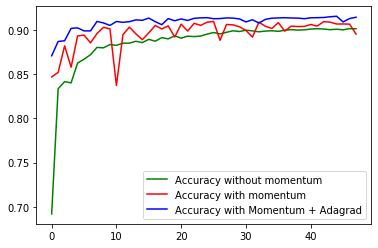

In [5]:
import matplotlib.pyplot as plt
plt.plot(range(len(model_no_momentum.accuracy_values)), model_no_momentum.accuracy_values,
         'g-', label = 'Accuracy without momentum')
plt.plot(range(len(model_momentum.accuracy_values)), model_momentum.accuracy_values,
         'r-', label = 'Accuracy with momentum')
plt.plot(range(len(model_momentum_adagrad.accuracy_values)), model_momentum_adagrad.accuracy_values,
         'b-', label = 'Accuracy with Momentum + Adagrad')
plt.legend(loc='best')
plt.show()

Now I'll compare our model with a Logistic Regression model from Scikit-Learn library

In [6]:
import datetime
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression

now = datetime.datetime.now()
best_model = SGD_logistic_regression(n_epochs = 2, learning_rate=0.12, momentum_const=0.9, adagrad=True)
best_model.fit(X_train_drop, y_train_drop)
pred = best_model.predict(X_test_drop)
print('timing: ', datetime.datetime.now() - now)
print('Our model accuracy: ', model_no_momentum.evaluate(y_test_drop, pred))

#Our models raining process includes normalization
normalizer = Normalizer()
X_train_drop = normalizer.fit_transform(X_train_drop, y_train_drop)
X_test_drop = normalizer.fit_transform(X_test_drop, y_test_drop)

now = datetime.datetime.now()
mod = LogisticRegression(max_iter=100)
mod.fit(X_train_drop, y_train_drop)
pred = mod.predict(X_test_drop)
print('timing: ', datetime.datetime.now() - now)
print('Scikit Learn Logistic Regression model accuracy: ', model_no_momentum.evaluate(y_test_drop, pred))

timing:  0:00:07.100541
Our model accuracy:  0.9194673430564363
timing:  0:00:05.126708
Scikit Learn Logistic Regression model accuracy:  0.9222574508560558


# Results
Our model reaches better accuracy with only 2 epochs of training process.
Our timing is also fine.

Now we'll set n_epochs param as a some bigger number to check if we can get better accuracy.

In [7]:
now = datetime.datetime.now()
best_model = SGD_logistic_regression(n_epochs = 10, learning_rate=0.12, momentum_const=0.9, adagrad=True)
best_model.fit(X_train_drop, y_train_drop)
pred = best_model.predict(X_test_drop)
print('timing: ', datetime.datetime.now() - now)
print('Our model accuracy: ', model_no_momentum.evaluate(y_test_drop, pred))

timing:  0:00:17.708350
Our model accuracy:  0.9255548509828789


Now we can tell that, our classifier is close to it's limit, in 2 epochs of running.